In [47]:
# import dependencies
#Load and inspect images using the Python Imaging Library (PIL)
from PIL import Image
import os
import numpy as np
from PIL import Image
import cv2
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import requests
import pickle
import pandas as pd

# data importing and cleaning

In [2]:
# Specify the directory containing the images
#image_dir = "/Users/ryanbusman/Desktop/Final_Project_X_RAy/Data/X_Ray Image DataSet"
image_dir = "../Data/X_Ray Image DataSet"
# Iterate over the files in the directory

In [3]:
# check 1 file
file_path = image_dir+'/Benign/B0003_0002.png'
# Load the image
image = Image.open(file_path)
# Convert the image to grayscale if needed
if image.mode != "L":
    image = image.convert("L")

In [4]:
#Preprocess Images for Machine Learning.  Resize the images to a consistent size 
# Specify the target size
target_size = (224, 224)
# Resize the image
resized_image = image.resize(target_size, resample = Image.LANCZOS)

In [5]:
# Convert the image to a NumPy array 
image_array = np.array(resized_image)
print(image_array)

[[235 235 235 ... 234 234 234]
 [236 235 235 ... 234 235 234]
 [235 236 235 ... 235 235 235]
 ...
 [236 235 235 ... 234 235 234]
 [235 235 235 ... 235 235 234]
 [235 235 235 ... 234 234 234]]


In [6]:
  # Apply denoising filter and normalize
denoised_image_array = cv2.fastNlMeansDenoising(image_array, None, h=10, templateWindowSize=7, 
                                                searchWindowSize=21).astype(np.float32)/255
display(denoised_image_array)
display(denoised_image_array.shape)

array([[0.9254902 , 0.9254902 , 0.9254902 , ..., 0.92156863, 0.92156863,
        0.92156863],
       [0.9254902 , 0.9254902 , 0.9254902 , ..., 0.92156863, 0.92156863,
        0.92156863],
       [0.9254902 , 0.9254902 , 0.9254902 , ..., 0.92156863, 0.92156863,
        0.92156863],
       ...,
       [0.92156863, 0.92156863, 0.92156863, ..., 0.92156863, 0.92156863,
        0.92156863],
       [0.9254902 , 0.9254902 , 0.9254902 , ..., 0.92156863, 0.92156863,
        0.92156863],
       [0.9254902 , 0.9254902 , 0.9254902 , ..., 0.92156863, 0.92156863,
        0.92156863]], dtype=float32)

(224, 224)

In [7]:
#Add batch dimension
reshaped_image_array = np.expand_dims(denoised_image_array, axis=0)

# For grayscale images, the "channels" dimension must be added
# Add a channel dimension for grayscale images
reshaped_image_array = np.expand_dims(reshaped_image_array, axis=-1)

# View the shape
reshaped_image_array.shape

(1, 224, 224, 1)

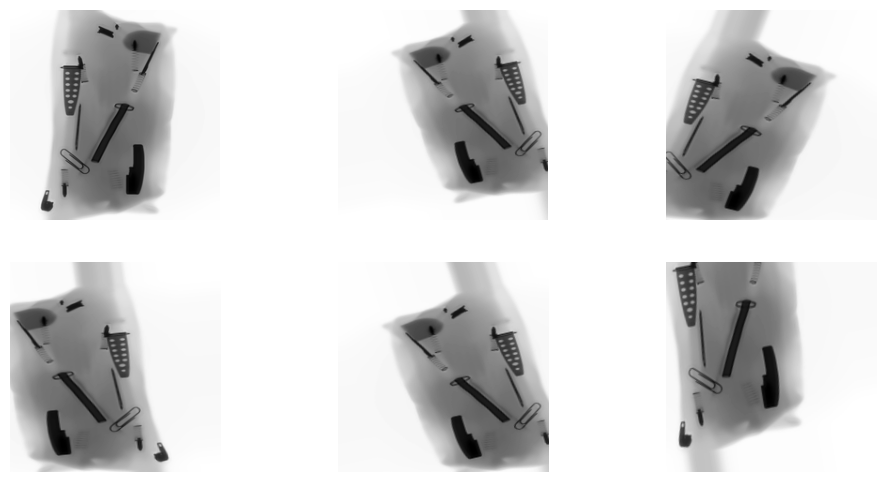

In [10]:
# Create the ImageDataGenerator object with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Generate augmented images
augmented_images = []
for _ in range(5):  # Augment the image 5 times for variety
    augmented_image = next(datagen.flow(reshaped_image_array, batch_size=1))[0]
    augmented_images.append(augmented_image)

# Visualize the original and augmented images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    if i == 0:
        plt.imshow((reshaped_image_array[0, :, :, 0]*255).astype('uint8'), cmap='gray')  # Original image
    else:
        plt.imshow((augmented_images[i - 1][:, :, 0]*255).astype('uint8'), cmap='gray')
    plt.axis('off')

plt.show()

In [118]:
# define independent and dependent
X =augmented_image
y = np.zeros(X.shape[0]) # not dangerous
# Label encode the y data
#y_encoder = LabelEncoder().fit(y)
#y = y_encoder.transform(y)

# Convert values to numpy arrays
X = np.array(X)

# Split the training dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## cnn model 

In [114]:
# Define a CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10


ValueError: Exception encountered when calling Conv2D.call().

[1mNegative dimension size caused by subtracting 3 from 1 for '{{node sequential_25_1/conv2d_25_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_25_1/ExpandDims, sequential_25_1/conv2d_25_1/convolution/ReadVariableOp)' with input shapes: [?,224,1,1], [3,3,1,32].[0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(None, 224, 1, 1), dtype=float32)

In [119]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print('y_train shape:', y_train.shape)

X_train shape: (179, 224, 1)
X_test shape: (45, 224, 1)
y_train shape: (179,)


In [120]:
np.array(augmented_image).shape

(224, 224, 1)

In [115]:
augmented_image.shape

(224, 224, 1)